In [152]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import subplot,imshow,title,gray,NullLocator
import scipy.misc as mi
import scipy.special as sp
from PIL import Image
from itertools import chain
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import Callback

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D,MaxPooling2D

#from keras import backend as K
#K.set_image_dim_ordering('th')

In [15]:
# visualizza dati
def displayData(X, t, rows=10, cols=10, img_ind=None, size =16, class_value = False):
    if len(X)>rows*cols:
        img_ind = np.random.permutation(len(X))[0:rows * cols]
    else:
        img_ind = range(rows*cols)
    fig = plt.figure(figsize = (size,size))
    fig.patch.set_facecolor('white')
    ax = fig.gca()
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.imshow([255-x for x in X[img_ind[i]]], cmap='gray', interpolation='gaussian')
        if class_value:
            plt.title("{}".format(t[img_ind[i]]),fontsize = 20)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.axis('off')
    plt.subplots_adjust(top=1)
    plt.show()

In [16]:
def plotData(X, Y, c, npixel=28):
    m, n = X.shape
    image = np.array(X[c,:])
    plt.figure(figsize = (6,6))
    plt.imshow((image.reshape(npixel, npixel)), cmap='Greys', interpolation='quadric')
    plt.show()

In [135]:
def plotMeasure(history_train, history_test, title=''):
    plt.figure(figsize = (12,8))
    plt.plot(history_train, marker='o', markersize=5, label='Train')
    plt.plot(history_test, marker='o', markersize=5, label='Test')
    plt.legend()
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.title(title)
    plt.show()

In [18]:
def save_model(m,filename):
    model_json = m.to_json()
    with open(filename+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    m.save_weights(filename+".h5")
    print("Saved model to disk")

In [19]:
def load_model(filename):
    json_file = open(filename+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    m = model_from_json(loaded_model_json)
    # load weights into new model
    m.load_weights(filename+".h5")
    print("Loaded model from disk")
    return m

Fissa il numero di classi. Leggi i dati.

In [102]:
nb_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()

Visualizza la dimensione di $X_{train}$ e $X_{test}$. Le immagini rappresentate risultano indicizzate dalla prima dimensione e definite come matrici $28\times 28$. I valori nelle matrici sono interi compresi tra $0$ e $255$.

In [103]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [104]:
X_train[0,:,:]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

Esempio: i primi 100 elementi nel training set

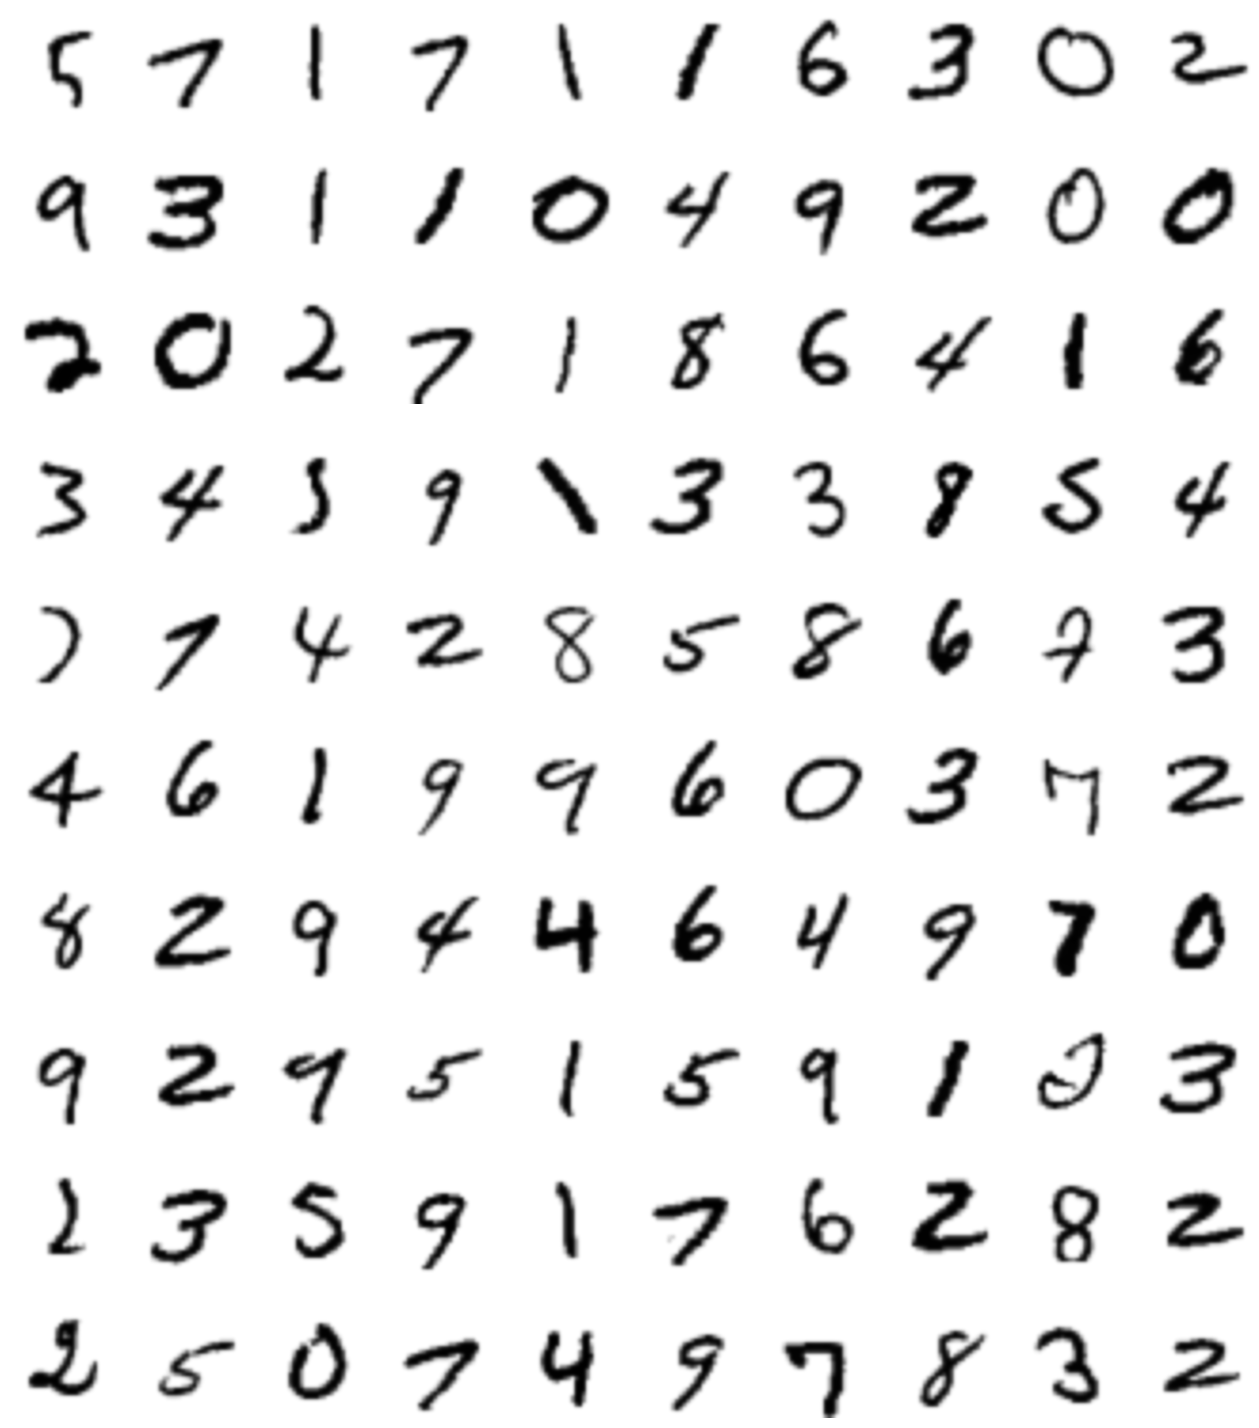

In [22]:
displayData(X_train[100:200], y_train[100:200])

Esempio: i primi 100 elementi nel training set con la relativa classe

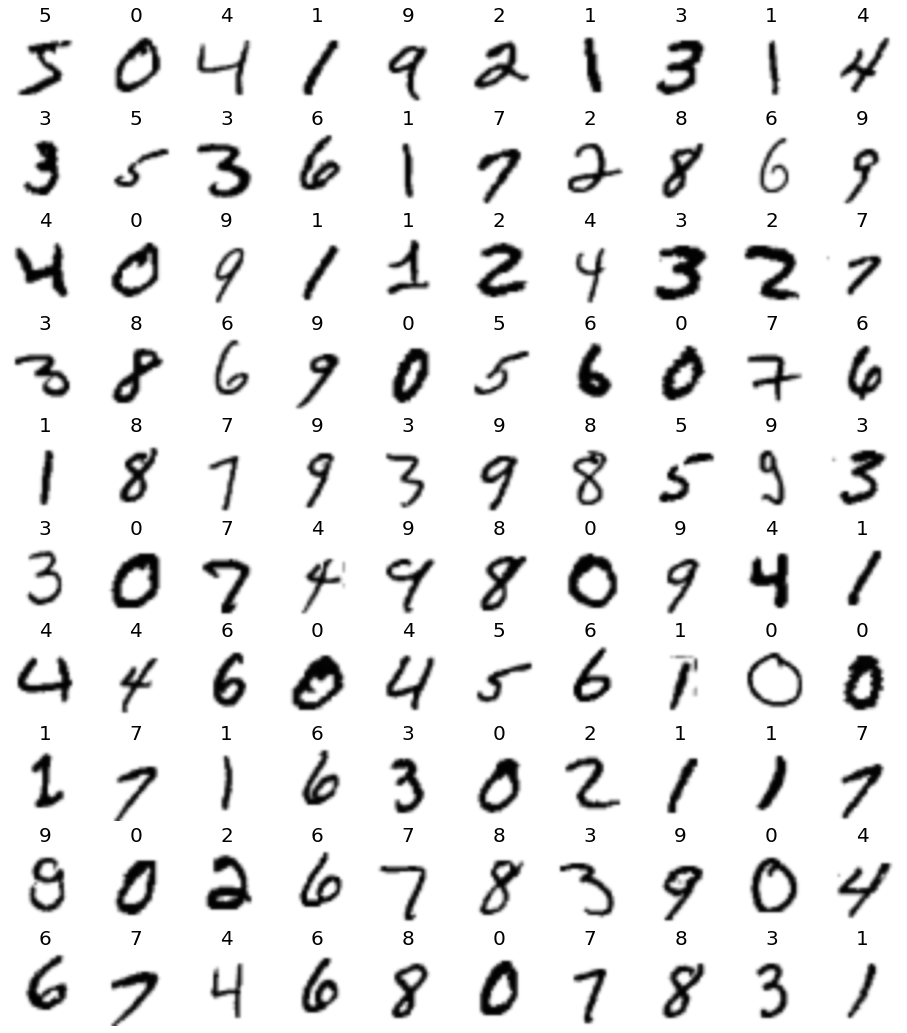

In [16]:
displayData(X_train[0:100], y_train[0:100], class_value=True)

Modifica la rappresentazione degli elementi da matrici $28\times 28$ a vettori di dimensione $784$, con elementi reali compresi tra $0$ e $1$.

In [106]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [107]:
X_train[0,:].shape

(784,)

Le classi vengono codificate nella forma $\textit{one-hot}$, come vettori di dimensione $10$ (il numero delle classi) con elementi pari a $0$, eccetto quello di indice pari al valore da codificare.

In [27]:
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

In [109]:
y_train[0:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [110]:
Y_train[0:5,:]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

Costruisci il modello (insieme delle possibili funzioni), definendo una funzione di costo e un metodo per l'ottimizzazione

In [127]:
# softmax regression
model0 = Sequential()
model0.add(Dense(10, input_shape=(784,)))
model0.add(Activation('softmax'))
model0.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam')

In [112]:
model0.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 10)                7850      
_________________________________________________________________
activation_8 (Activation)    (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


Cerca la migliore funzione possibile, rispetto ai dati disponibili

In [128]:
history0 = model0.fit(X_train, Y_train, batch_size=2048, epochs=50, verbose=1, validation_data=(X_test, Y_test))

Epoch 1/50
30/30 [==============================] - 1s 23ms/step - loss: 2.0706 - acc: 0.3006 - val_loss: 1.3129 - val_acc: 0.7526
Epoch 2/50
30/30 [==============================] - 0s 14ms/step - loss: 1.1921 - acc: 0.7719 - val_loss: 0.8757 - val_acc: 0.8284
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.8428 - acc: 0.8284 - val_loss: 0.6908 - val_acc: 0.8520
Epoch 4/50
30/30 [==============================] - 0s 14ms/step - loss: 0.6869 - acc: 0.8481 - val_loss: 0.5923 - val_acc: 0.8691
Epoch 5/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6009 - acc: 0.8607 - val_loss: 0.5309 - val_acc: 0.8793
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.5402 - acc: 0.8718 - val_loss: 0.4877 - val_acc: 0.8855
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 0.5016 - acc: 0.8775 - val_loss: 0.4558 - val_acc: 0.8912
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.4676 - a

In [145]:
save_model(model0, 'softmax')

Saved model to disk


In [148]:
history0_df = pd.DataFrame(history0.history)

In [149]:
history0_df.head()

,loss,acc,val_loss,val_acc
0,1.817510,0.465283,1.312906,0.7526
1,1.091161,0.786833,0.875687,0.8284
2,0.800041,0.833033,0.690839,0.8520
3,0.663099,0.851867,0.592271,0.8691
4,0.583235,0.865083,0.530862,0.8793


Loss: errore stimato

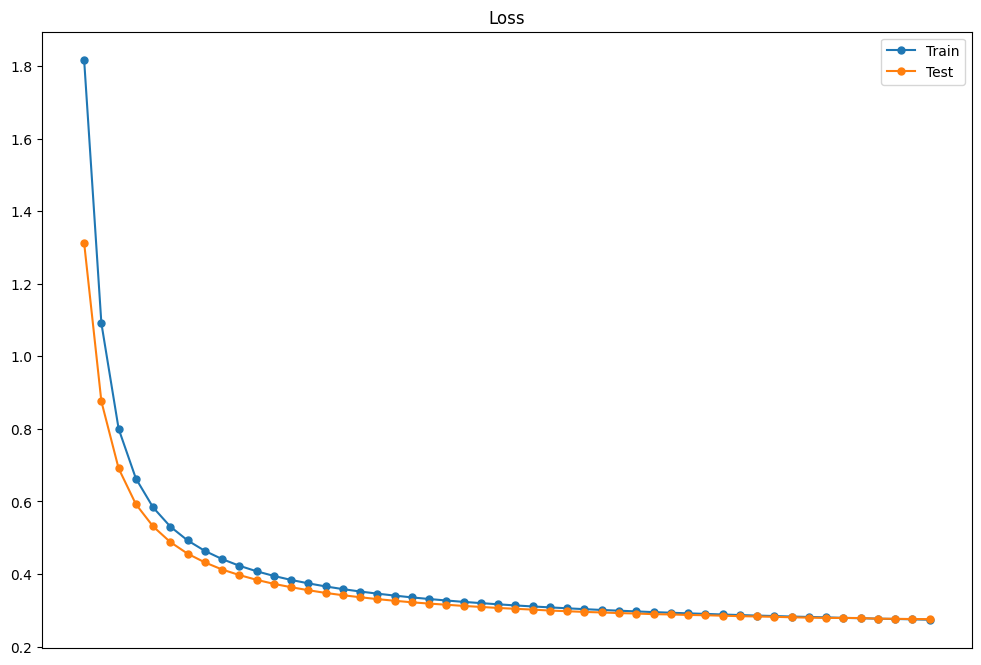

In [150]:
plotMeasure(history0_df.loss, history0_df.val_loss, 'Loss')

Accuracy: frazione di risposte corrette

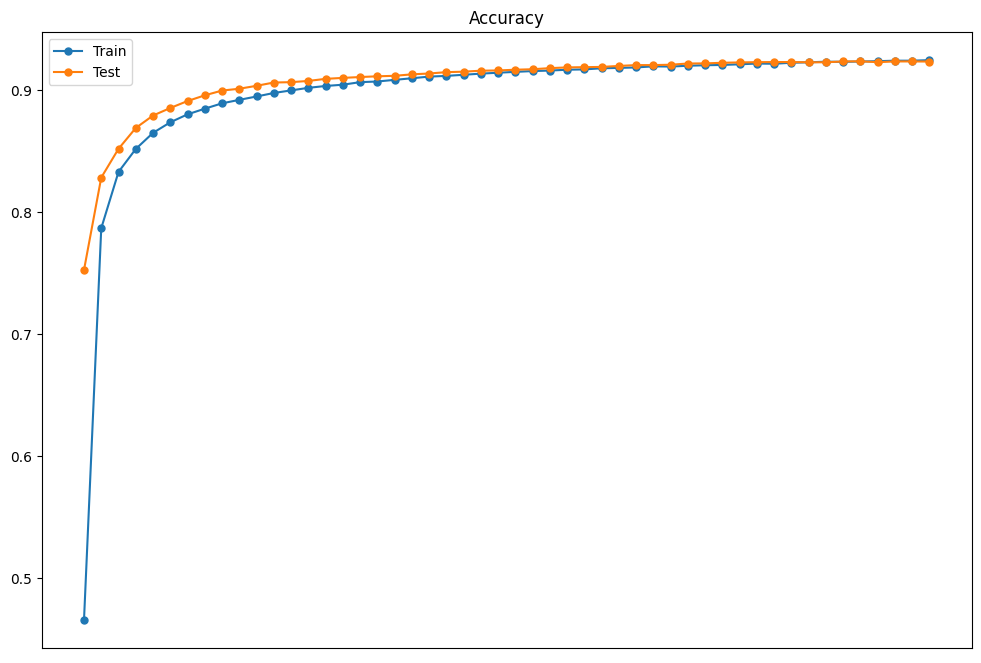

In [151]:
plotMeasure(history0_df.acc, history0_df.val_acc, 'Accuracy')

In [139]:
predictions_train = np.argmax(model0.predict(X_train), axis=-1)

In [140]:
confusion_matrix(y_train, predictions_train)

array([[5731,    1,   20,   13,   12,   44,   40,    9,   49,    4],
       [   1, 6557,   35,   22,    8,   32,    4,   13,   60,   10],
       [  40,   69, 5347,   90,   83,   23,   70,   83,  135,   18],
       [  22,   29,  125, 5498,    6,  206,   24,   60,  111,   50],
       [  12,   26,   34,    7, 5464,    5,   52,   16,   37,  189],
       [  66,   38,   32,  156,   64, 4782,   85,   17,  132,   49],
       [  36,   19,   30,    0,   41,   73, 5682,    3,   33,    1],
       [  16,   38,   63,   19,   49,    9,    3, 5856,   12,  200],
       [  33,  119,   52,  141,   28,  153,   37,   20, 5194,   74],
       [  25,   26,   19,   83,  159,   35,    4,  167,   36, 5395]])

In [141]:
accuracy_score(y_train, predictions_train)

0.9251

Accuracy: $$\frac{\text{\# elementi predetti correttamente}}{\text{\# elementi}}$$

Precision classe $i$: $$\frac{\text{\# elementi della classe $i$ predetti correttamente}}{\text{\# elementi predetti della classe $i$}}$$

Recall classe $i$: $$\frac{\text{\# elementi della classe $i$ predetti correttamente}}{\text{\# elementi della classe $i$}}$$

F-score classe $i$: $$\frac{\text{Precision classe $i$} \times \text{Recall classe $i$}}{\text{Precision classe $i$}+\text{Recall classe $i$}}$$

In [158]:
meas = precision_recall_fscore_support(y_train, predictions_train, average=None)
print('Training set')
for i in range(10):
  print(f'Class {i}, {meas[3][i]} elements: precision={meas[0][i]:5.2f}, recall={meas[1][i]:5.2f}, f-score={meas[2][i]:5.2f}')

Training set
Class 0, 5923 elements: precision= 0.96, recall= 0.97, f-measure= 0.96
Class 1, 6742 elements: precision= 0.95, recall= 0.97, f-measure= 0.96
Class 2, 5958 elements: precision= 0.93, recall= 0.90, f-measure= 0.91
Class 3, 6131 elements: precision= 0.91, recall= 0.90, f-measure= 0.90
Class 4, 5842 elements: precision= 0.92, recall= 0.94, f-measure= 0.93
Class 5, 5421 elements: precision= 0.89, recall= 0.88, f-measure= 0.89
Class 6, 5918 elements: precision= 0.95, recall= 0.96, f-measure= 0.95
Class 7, 6265 elements: precision= 0.94, recall= 0.93, f-measure= 0.94
Class 8, 5851 elements: precision= 0.90, recall= 0.89, f-measure= 0.89
Class 9, 5949 elements: precision= 0.90, recall= 0.91, f-measure= 0.90


In [159]:
predictions_test = np.argmax(model0.predict(X_test), axis=-1) 

In [160]:
confusion_matrix(y_test, predictions_test)

array([[ 961,    0,    1,    1,    0,    5,    6,    3,    3,    0],
       [   0, 1113,    2,    3,    1,    2,    4,    1,    9,    0],
       [   8,    9,  918,   16,   10,    4,   12,   10,   42,    3],
       [   4,    2,   16,  918,    1,   28,    3,   11,   19,    8],
       [   1,    2,    4,    0,  917,    0,   12,    3,    9,   34],
       [   8,    2,    3,   30,   10,  778,   16,    6,   32,    7],
       [   9,    3,    6,    1,    7,   12,  916,    2,    2,    0],
       [   1,   10,   21,    8,    7,    0,    0,  943,    2,   36],
       [   7,    8,    6,   24,    9,   25,   11,   13,  863,    8],
       [  12,    5,    1,   10,   32,    9,    0,   23,    8,  909]])

In [161]:
accuracy_score(y_test, predictions_test)

0.9236

In [163]:
meas = precision_recall_fscore_support(y_test, predictions_test, average=None)
print('Test set')
for i in range(10):
  print(f'Class {i}, {meas[3][i]} elements: precision={meas[0][i]:5.2f}, recall={meas[1][i]:5.2f}, f-score={meas[2][i]:5.2f}')

Test set
Class 0, 980 elements: precision= 0.95, recall= 0.98, f-score= 0.97
Class 1, 1135 elements: precision= 0.96, recall= 0.98, f-score= 0.97
Class 2, 1032 elements: precision= 0.94, recall= 0.89, f-score= 0.91
Class 3, 1010 elements: precision= 0.91, recall= 0.91, f-score= 0.91
Class 4, 982 elements: precision= 0.92, recall= 0.93, f-score= 0.93
Class 5, 892 elements: precision= 0.90, recall= 0.87, f-score= 0.89
Class 6, 958 elements: precision= 0.93, recall= 0.96, f-score= 0.95
Class 7, 1028 elements: precision= 0.93, recall= 0.92, f-score= 0.92
Class 8, 974 elements: precision= 0.87, recall= 0.89, f-score= 0.88
Class 9, 1009 elements: precision= 0.90, recall= 0.90, f-score= 0.90


In [41]:
w = model0.layers[0].get_weights()[0]

In [170]:
w[:,0]

array([ 0.2869764 ,  0.1894139 ,  0.16468635, -0.13580543,  0.20059325,
       -0.13654958,  0.23942184, -0.4618917 ,  0.49421012, -0.20186162],
      dtype=float32)

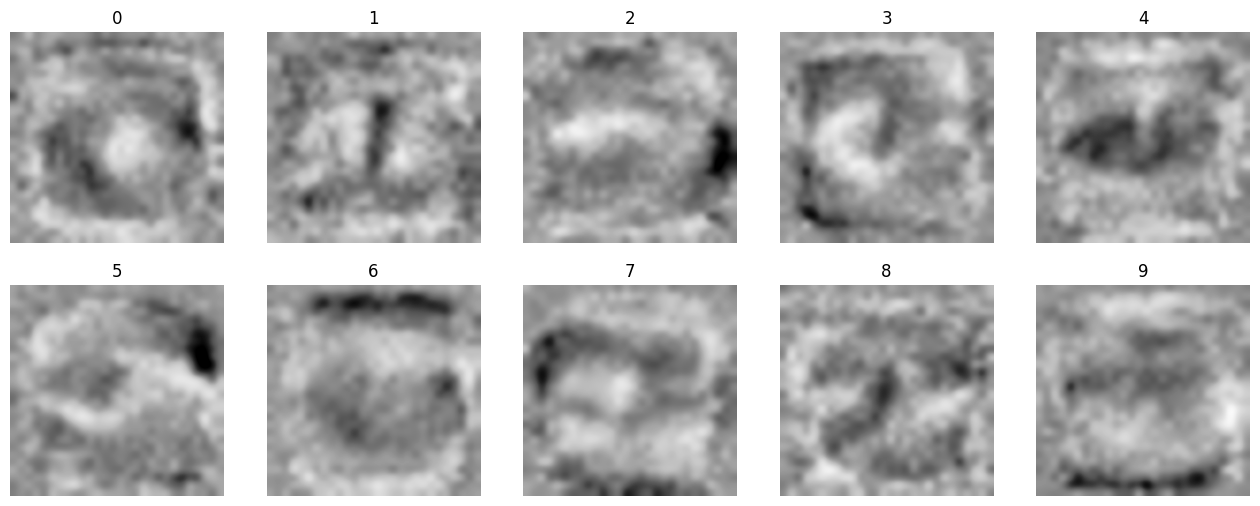

In [171]:
fig = plt.figure(figsize=(16,16))
fig.patch.set_facecolor('white')
for i in range(10):
    ax = subplot(2,5,i+1,frame_on=False, facecolor="#F8F8F8")
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())
    imshow(w[:,i].reshape(28,28), interpolation='quadric', 
           cmap=plt.get_cmap('Greys'), vmin=np.mean(w[:,i])-3.5*np.std(w[:,i]), 
           vmax=np.mean(w[:,i])+3.5*np.std(w[:,i]), aspect='auto')
    plt.title(i)
plt.subplots_adjust(top=0.4)
plt.show()

Elemento 2599


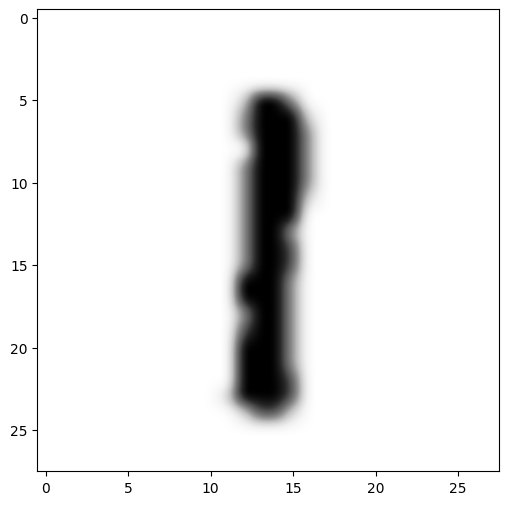

1, classificato come 1


In [49]:
c = np.random.randint(0, X_test.shape[0])
p= np.argmax(model0.predict(X_test[c:c+1,:]), axis=-1)
print(f"Elemento {c}")
plotData(X_test, y_test, c)
print(f"{y_test[c]}, classificato come {p[0]}")

In [172]:
# 3 layer NN
hidden_layer_width = 10
model1 = Sequential()
model1.add(Dense(hidden_layer_width, input_shape=(784,)))
model1.add(Activation('relu'))
model1.add(Dropout(0.2))
model1.add(Dense(10))
model1.add(Activation('softmax'))
model1.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam')

In [173]:
model1.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 10)                7850      
_________________________________________________________________
activation_13 (Activation)   (None, 10)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 10)                110       
_________________________________________________________________
activation_14 (Activation)   (None, 10)                0         
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#model1 = load_model_weights('nn3', model1)

In [174]:
history1 = model1.fit(X_train, Y_train, batch_size=512, epochs=50, verbose=1, validation_data=(X_test, Y_test))

Epoch 1/50
118/118 [==============================] - 11s 34ms/step - loss: 1.9462 - acc: 0.2860 - val_loss: 0.9211 - val_acc: 0.7985
Epoch 2/50
118/118 [==============================] - 2s 15ms/step - loss: 1.0667 - acc: 0.6512 - val_loss: 0.6252 - val_acc: 0.8514
Epoch 3/50
118/118 [==============================] - 2s 15ms/step - loss: 0.8779 - acc: 0.6978 - val_loss: 0.5371 - val_acc: 0.8666
Epoch 4/50
118/118 [==============================] - 2s 19ms/step - loss: 0.7879 - acc: 0.7252 - val_loss: 0.4624 - val_acc: 0.8795
Epoch 5/50
118/118 [==============================] - 2s 19ms/step - loss: 0.7183 - acc: 0.7509 - val_loss: 0.4262 - val_acc: 0.8891
Epoch 6/50
118/118 [==============================] - 2s 19ms/step - loss: 0.6678 - acc: 0.7737 - val_loss: 0.3977 - val_acc: 0.8937
Epoch 7/50
118/118 [==============================] - 2s 19ms/step - loss: 0.6394 - acc: 0.7853 - val_loss: 0.3815 - val_acc: 0.8973
Epoch 8/50
118/118 [==============================] - 2s 19ms/step -

In [175]:
save_model(model1,'nn3')

Saved model to disk


In [176]:
history1_df = pd.DataFrame(history1.history)

In [177]:
history1_df.head()

,loss,acc,val_loss,val_acc
0,1.622650,0.437900,0.921109,0.7985
1,1.001746,0.667267,0.625225,0.8514
2,0.863436,0.700150,0.537067,0.8666
3,0.769318,0.731117,0.462395,0.8795
4,0.707564,0.756250,0.426226,0.8891


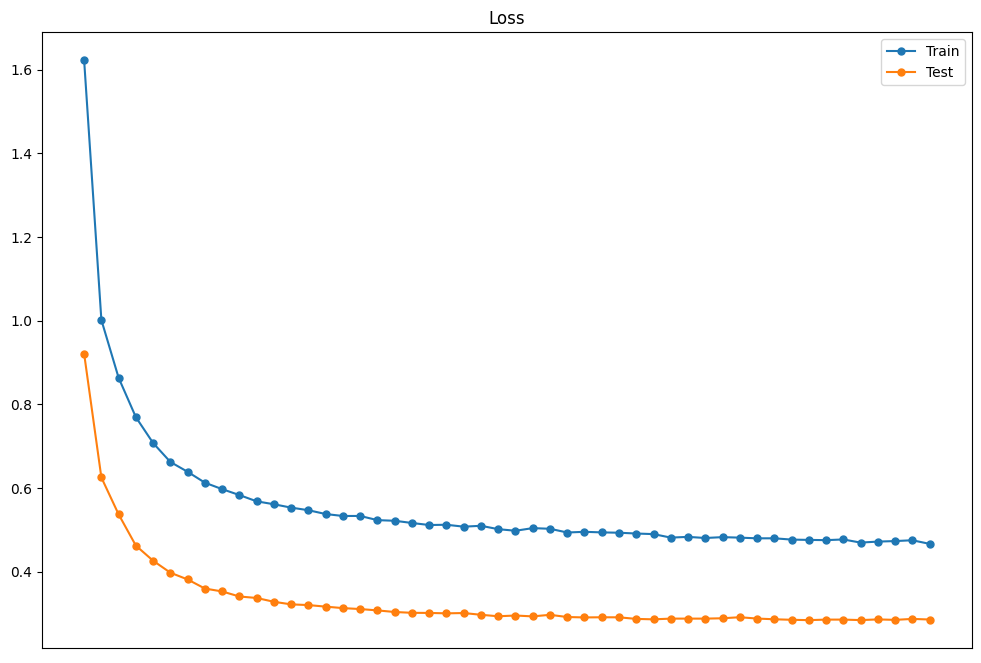

In [178]:
plotMeasure(history1_df.loss, history1_df.val_loss, 'Loss')

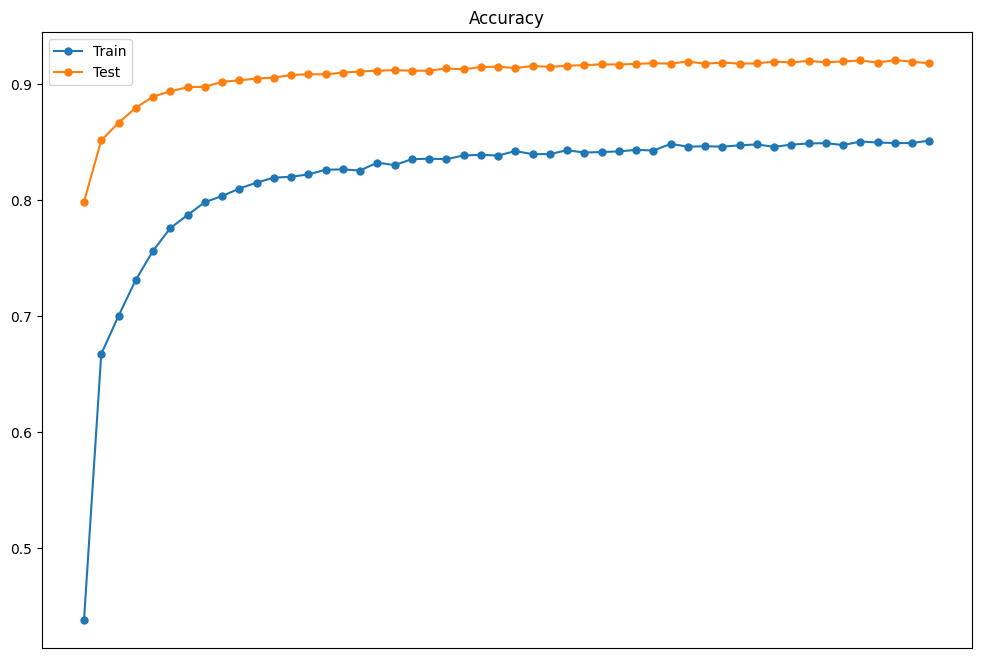

In [179]:
plotMeasure(history1_df.acc, history1_df.val_acc, 'Accuracy')

In [180]:
predictions_train = np.argmax(model1.predict(X_train), axis=-1)

In [181]:
confusion_matrix(y_train, predictions_train)

array([[5762,    3,   20,    3,   23,   14,   45,   19,   29,    5],
       [   1, 6538,   39,   17,    7,   26,    3,   17,   84,   10],
       [  38,   44, 5480,   47,   80,   10,   69,   67,  108,   15],
       [  27,   25,  143, 5437,    7,  299,    9,   67,   67,   50],
       [   9,    8,   23,    4, 5473,   26,   62,   10,   11,  216],
       [ 129,   26,   30,  157,   92, 4705,   54,   13,  156,   59],
       [  60,   14,   33,    0,   46,   54, 5658,    0,   52,    1],
       [  16,   43,   36,   27,   50,    3,    3, 5924,    8,  155],
       [  37,  152,   86,   38,   50,  142,   39,   24, 5215,   68],
       [  21,   13,   11,   58,  217,   75,   18,  118,   16, 5402]])

In [182]:
accuracy_score(y_train, predictions_train)

0.9265666666666666

In [183]:
meas = precision_recall_fscore_support(y_train, predictions_train, average=None)
print('Training set')
for i in range(10):
  print(f'Class {i}, {meas[3][i]} elements: precision={meas[0][i]:5.2f}, recall={meas[1][i]:5.2f}, f-score={meas[2][i]:5.2f}')

Training set
Class 0, 5923 elements: precision= 0.94, recall= 0.97, f-score= 0.96
Class 1, 6742 elements: precision= 0.95, recall= 0.97, f-score= 0.96
Class 2, 5958 elements: precision= 0.93, recall= 0.92, f-score= 0.92
Class 3, 6131 elements: precision= 0.94, recall= 0.89, f-score= 0.91
Class 4, 5842 elements: precision= 0.91, recall= 0.94, f-score= 0.92
Class 5, 5421 elements: precision= 0.88, recall= 0.87, f-score= 0.87
Class 6, 5918 elements: precision= 0.95, recall= 0.96, f-score= 0.95
Class 7, 6265 elements: precision= 0.95, recall= 0.95, f-score= 0.95
Class 8, 5851 elements: precision= 0.91, recall= 0.89, f-score= 0.90
Class 9, 5949 elements: precision= 0.90, recall= 0.91, f-score= 0.91


In [184]:
predictions_test = np.argmax(model1.predict(X_test), axis=-1)

In [185]:
confusion_matrix(y_test, predictions_test)

array([[ 957,    0,    1,    1,    3,    6,    9,    1,    1,    1],
       [   0, 1109,    5,    4,    0,    2,    4,    1,   10,    0],
       [   8,    4,  940,    8,   14,    1,   11,   13,   29,    4],
       [   1,    6,   24,  893,    1,   49,    1,   12,    9,   14],
       [   0,    0,    4,    2,  912,    1,   16,    2,    5,   40],
       [  18,    4,    3,   44,   17,  755,   10,    3,   26,   12],
       [  16,    5,   16,    0,    8,    9,  895,    0,    8,    1],
       [   1,   12,   21,    7,    8,    1,    0,  944,    0,   34],
       [   9,   20,   11,    9,   12,   27,   10,    8,  856,   12],
       [   3,    7,    0,   10,   33,   19,    3,   16,    1,  917]])

In [186]:
accuracy_score(y_test, predictions_test)

0.9178

In [187]:
meas = precision_recall_fscore_support(y_test, predictions_test, average=None)
print('Test set')
for i in range(10):
  print(f'Class {i}, {meas[3][i]} elements: precision={meas[0][i]:5.2f}, recall={meas[1][i]:5.2f}, f-score={meas[2][i]:5.2f}')

Test set
Class 0, 980 elements: precision= 0.94, recall= 0.98, f-score= 0.96
Class 1, 1135 elements: precision= 0.95, recall= 0.98, f-score= 0.96
Class 2, 1032 elements: precision= 0.92, recall= 0.91, f-score= 0.91
Class 3, 1010 elements: precision= 0.91, recall= 0.88, f-score= 0.90
Class 4, 982 elements: precision= 0.90, recall= 0.93, f-score= 0.92
Class 5, 892 elements: precision= 0.87, recall= 0.85, f-score= 0.86
Class 6, 958 elements: precision= 0.93, recall= 0.93, f-score= 0.93
Class 7, 1028 elements: precision= 0.94, recall= 0.92, f-score= 0.93
Class 8, 974 elements: precision= 0.91, recall= 0.88, f-score= 0.89
Class 9, 1009 elements: precision= 0.89, recall= 0.91, f-score= 0.90


In [188]:
w0 = model1.layers[0].get_weights()[0]
w1 = model1.layers[3].get_weights()[0]
w = np.dot(w0,w1)

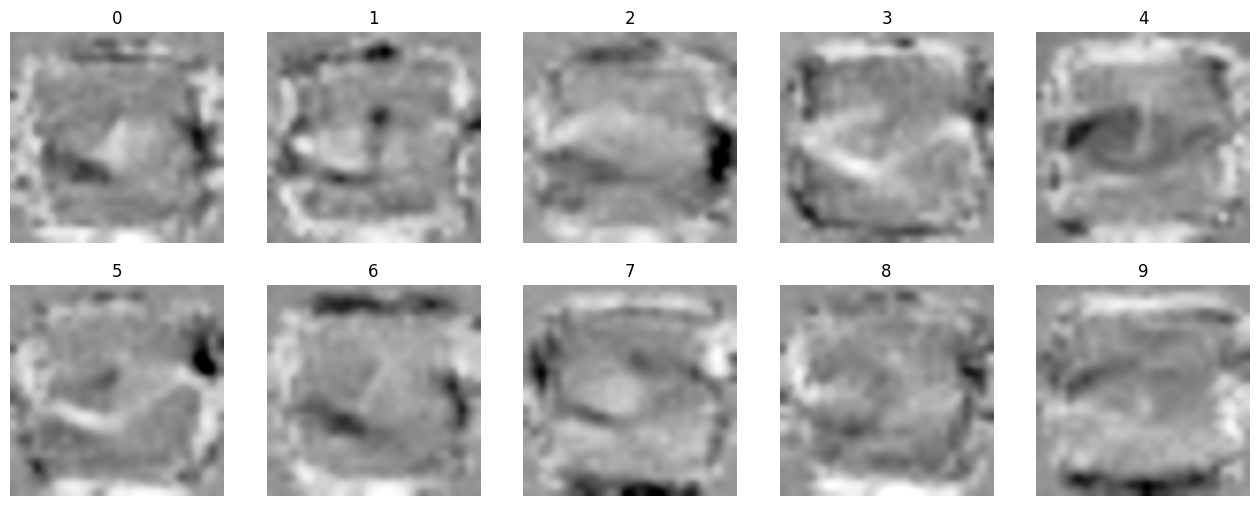

In [189]:
fig = plt.figure(figsize=(16,16))
fig.patch.set_facecolor('white')
for i in range(10):
    ax = subplot(2,5,i+1,frame_on=False, facecolor="#F8F8F8")
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())
    imshow(w[:,i].reshape(28,28), interpolation='quadric', 
           cmap=plt.get_cmap('Greys'), vmin=np.mean(w[:,i])-3.5*np.std(w[:,i]), 
           vmax=np.mean(w[:,i])+3.5*np.std(w[:,i]), aspect='auto')
    plt.title(i)
plt.subplots_adjust(top=0.4)
plt.show()

In [190]:
# 4 layer NN
hidden_layer1_width = 120
hidden_layer2_width = 50
model2 = Sequential()
model2.add(Dense(hidden_layer1_width, input_shape=(784,)))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(hidden_layer2_width))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(10))
model2.add(Activation('softmax'))

In [194]:
model2.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 120)               94200     
_________________________________________________________________
activation_15 (Activation)   (None, 120)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 50)                6050      
_________________________________________________________________
activation_16 (Activation)   (None, 50)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 10)              

In [191]:
model2.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam')

In [ ]:
#model2 = load_model_weights('nn4', model2)

In [193]:
history2 = model2.fit(X_train, Y_train, batch_size=1024, epochs=10, verbose=1, validation_data=(X_test, Y_test))

Epoch 1/10
59/59 [==============================] - 1s 15ms/step - loss: 0.1241 - acc: 0.9626 - val_loss: 0.0912 - val_acc: 0.9729
Epoch 2/10
59/59 [==============================] - 1s 17ms/step - loss: 0.1154 - acc: 0.9661 - val_loss: 0.0896 - val_acc: 0.9734
Epoch 3/10
59/59 [==============================] - 1s 16ms/step - loss: 0.1105 - acc: 0.9671 - val_loss: 0.0856 - val_acc: 0.9742
Epoch 4/10
59/59 [==============================] - 1s 16ms/step - loss: 0.1056 - acc: 0.9688 - val_loss: 0.0839 - val_acc: 0.9750
Epoch 5/10
59/59 [==============================] - 1s 16ms/step - loss: 0.0979 - acc: 0.9704 - val_loss: 0.0788 - val_acc: 0.9755
Epoch 6/10
59/59 [==============================] - 1s 17ms/step - loss: 0.0953 - acc: 0.9710 - val_loss: 0.0788 - val_acc: 0.9750
Epoch 7/10
59/59 [==============================] - 1s 17ms/step - loss: 0.0911 - acc: 0.9725 - val_loss: 0.0750 - val_acc: 0.9775
Epoch 8/10
59/59 [==============================] - 1s 17ms/step - loss: 0.0861 - a

In [195]:
save_model(model2,'nn4')

Saved model to disk


In [196]:
history2_df = pd.DataFrame(history2.history)

In [197]:
history2_df.head()

,loss,acc,val_loss,val_acc
0,0.124132,0.962567,0.091210,0.9729
1,0.115410,0.966067,0.089637,0.9734
2,0.110461,0.967083,0.085646,0.9742
3,0.105612,0.968767,0.083932,0.9750
4,0.097916,0.970350,0.078786,0.9755


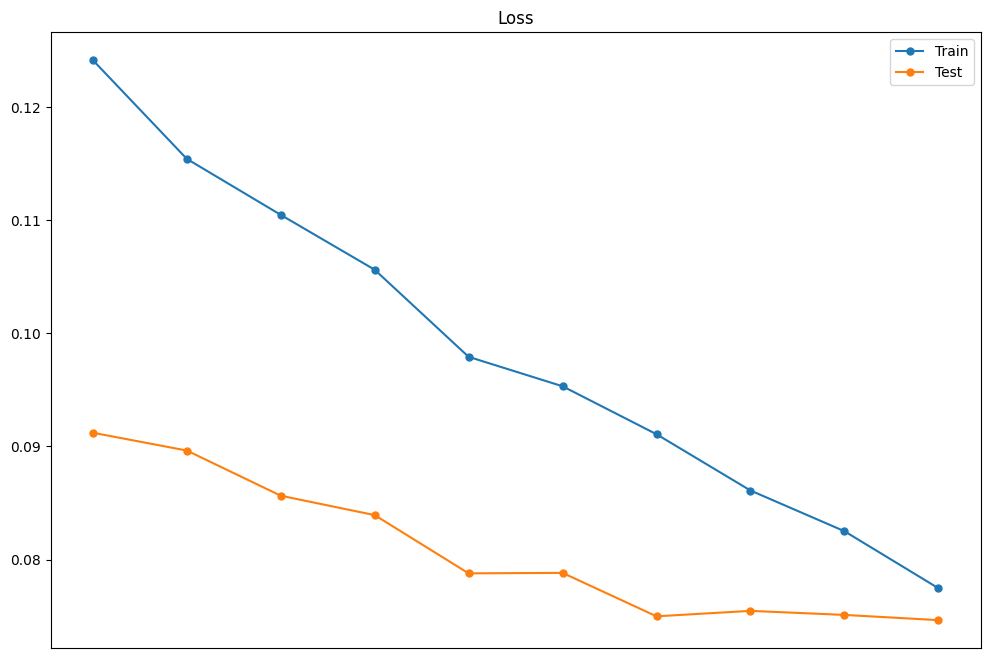

In [198]:
plotMeasure(history2_df.loss, history2_df.val_loss, 'Loss')

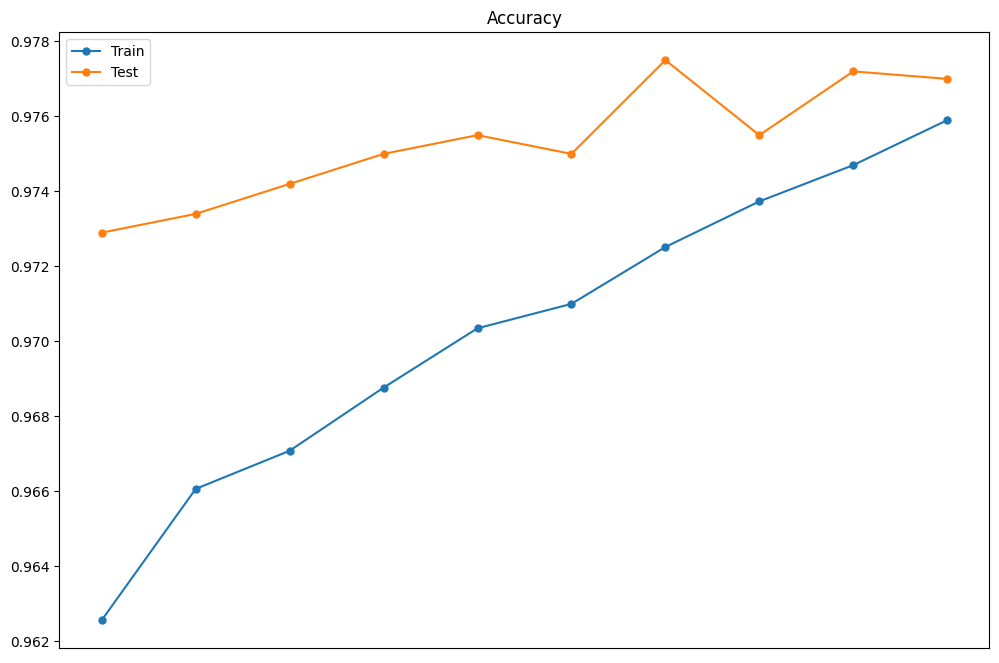

In [199]:
plotMeasure(history2_df.acc, history2_df.val_acc, 'Accuracy')

In [200]:
predictions_train = np.argmax(model2.predict(X_train), axis=-1)

In [201]:
confusion_matrix(y_train, predictions_train)

array([[5897,    1,    2,    1,    1,    1,    8,    0,    9,    3],
       [   1, 6710,   12,    2,    3,    0,    2,    6,    5,    1],
       [  10,    4, 5914,    4,    6,    1,    0,   10,    7,    2],
       [   4,    3,   29, 6019,    0,   21,    0,   10,   34,   11],
       [   2,    9,   11,    0, 5770,    0,    9,    4,    2,   35],
       [   9,    1,    4,   20,    0, 5357,   11,    1,   11,    7],
       [  10,    4,    1,    0,    4,   12, 5883,    0,    4,    0],
       [   3,   18,   30,    3,    9,    1,    0, 6177,    3,   21],
       [   6,   25,    8,    7,    1,   13,   12,    3, 5771,    5],
       [   8,    6,    0,   23,   16,   12,    1,   19,   16, 5848]])

In [202]:
accuracy_score(y_train, predictions_train)

0.9891

In [203]:
meas = precision_recall_fscore_support(y_train, predictions_train, average=None)
print('Training set')
for i in range(10):
  print(f'Class {i}, {meas[3][i]} elements: precision={meas[0][i]:5.2f}, recall={meas[1][i]:5.2f}, f-score={meas[2][i]:5.2f}')

Training set
Class 0, 5923 elements: precision= 0.99, recall= 1.00, f-score= 0.99
Class 1, 6742 elements: precision= 0.99, recall= 1.00, f-score= 0.99
Class 2, 5958 elements: precision= 0.98, recall= 0.99, f-score= 0.99
Class 3, 6131 elements: precision= 0.99, recall= 0.98, f-score= 0.99
Class 4, 5842 elements: precision= 0.99, recall= 0.99, f-score= 0.99
Class 5, 5421 elements: precision= 0.99, recall= 0.99, f-score= 0.99
Class 6, 5918 elements: precision= 0.99, recall= 0.99, f-score= 0.99
Class 7, 6265 elements: precision= 0.99, recall= 0.99, f-score= 0.99
Class 8, 5851 elements: precision= 0.98, recall= 0.99, f-score= 0.99
Class 9, 5949 elements: precision= 0.99, recall= 0.98, f-score= 0.98


In [204]:
predictions_test = np.argmax(model2.predict(X_test), axis=-1)

In [205]:
confusion_matrix(y_test, predictions_test)

array([[ 969,    1,    1,    1,    0,    2,    3,    1,    2,    0],
       [   0, 1124,    4,    0,    0,    2,    3,    0,    2,    0],
       [   3,    2, 1015,    2,    1,    0,    2,    3,    4,    0],
       [   1,    0,    2,  991,    0,    6,    0,    4,    5,    1],
       [   1,    0,    6,    0,  957,    0,    3,    2,    2,   11],
       [   2,    0,    0,    7,    2,  871,    3,    0,    5,    2],
       [   7,    3,    2,    1,    3,    5,  934,    0,    3,    0],
       [   1,    6,   12,    3,    0,    1,    0,  998,    0,    7],
       [   4,    1,    4,    4,    4,    4,    3,    3,  945,    2],
       [   3,    6,    1,    7,    8,    6,    1,    6,    5,  966]])

In [206]:
accuracy_score(y_test, predictions_test)

0.977

In [208]:
meas = precision_recall_fscore_support(y_test, predictions_test, average=None)
print('Test set')
for i in range(10):
  print(f'Class {i}, {meas[3][i]} elements: precision={meas[0][i]:5.2f}, recall={meas[1][i]:5.2f}, f-score={meas[2][i]:5.2f}')

Test set
Class 0, 980 elements: precision= 0.98, recall= 0.99, f-score= 0.98
Class 1, 1135 elements: precision= 0.98, recall= 0.99, f-score= 0.99
Class 2, 1032 elements: precision= 0.97, recall= 0.98, f-score= 0.98
Class 3, 1010 elements: precision= 0.98, recall= 0.98, f-score= 0.98
Class 4, 982 elements: precision= 0.98, recall= 0.97, f-score= 0.98
Class 5, 892 elements: precision= 0.97, recall= 0.98, f-score= 0.97
Class 6, 958 elements: precision= 0.98, recall= 0.97, f-score= 0.98
Class 7, 1028 elements: precision= 0.98, recall= 0.97, f-score= 0.98
Class 8, 974 elements: precision= 0.97, recall= 0.97, f-score= 0.97
Class 9, 1009 elements: precision= 0.98, recall= 0.96, f-score= 0.97


In [209]:
w0 = model2.layers[0].get_weights()[0]
w1 = model2.layers[3].get_weights()[0]
w2 = model2.layers[6].get_weights()[0]
w = np.dot(np.dot(w0,w1),w2)

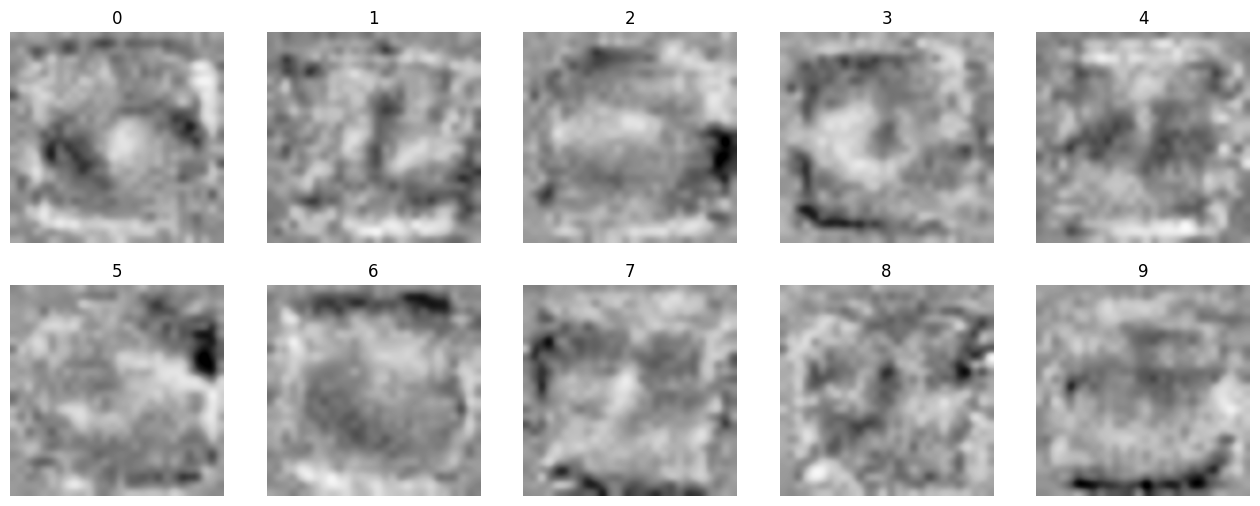

In [210]:
fig = plt.figure(figsize=(16,16))
fig.patch.set_facecolor('white')
for i in range(10):
    ax = subplot(2,5,i+1,frame_on=False, facecolor="#F8F8F8")
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())
    imshow(w[:,i].reshape(28,28), interpolation='quadric', 
           cmap=plt.get_cmap('Greys'), vmin=np.mean(w[:,i])-3.5*np.std(w[:,i]), 
           vmax=np.mean(w[:,i])+3.5*np.std(w[:,i]), aspect='auto')
    plt.title(i)
plt.subplots_adjust(top=0.4)
plt.show()

In [211]:
model3 = Sequential()
model3.add(Conv2D(30, (5, 5), input_shape=(28, 28, 1), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(15, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(50, activation='relu'))
model3.add(Dense(10, activation='softmax'))

In [212]:
model3.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 24, 24, 30)        780       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 15)        4065      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 15)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 5, 15)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 375)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)             

In [214]:
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [99]:
X_train_c = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test_c = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

In [ ]:
#model3 = load_model_weights('cnn', model3)

In [215]:
history3 = model3.fit(X_train_c, Y_train, batch_size=1024, epochs=10, verbose=1, validation_data=(X_test_c, Y_test))

Epoch 1/10
59/59 [==============================] - 51s 858ms/step - loss: 1.5790 - acc: 0.4779 - val_loss: 0.2853 - val_acc: 0.9192
Epoch 2/10
59/59 [==============================] - 53s 905ms/step - loss: 0.2947 - acc: 0.9111 - val_loss: 0.1319 - val_acc: 0.9604
Epoch 3/10
59/59 [==============================] - 56s 957ms/step - loss: 0.1554 - acc: 0.9522 - val_loss: 0.0847 - val_acc: 0.9734
Epoch 4/10
59/59 [==============================] - 46s 771ms/step - loss: 0.1114 - acc: 0.9664 - val_loss: 0.0659 - val_acc: 0.9786
Epoch 5/10
59/59 [==============================] - 45s 763ms/step - loss: 0.0909 - acc: 0.9733 - val_loss: 0.0506 - val_acc: 0.9838
Epoch 6/10
59/59 [==============================] - 47s 800ms/step - loss: 0.0781 - acc: 0.9772 - val_loss: 0.0438 - val_acc: 0.9862
Epoch 7/10
59/59 [==============================] - 38s 637ms/step - loss: 0.0655 - acc: 0.9800 - val_loss: 0.0415 - val_acc: 0.9865
Epoch 8/10
59/59 [==============================] - 32s 535ms/step - 

In [216]:
save_model(model3,'cnn')

Saved model to disk


In [217]:
history3_df = pd.DataFrame(history3.history) 

In [218]:
history3_df.head()

,loss,acc,val_loss,val_acc
0,1.017185,0.674000,0.285294,0.9192
1,0.250083,0.924233,0.131867,0.9604
2,0.145778,0.955783,0.084733,0.9734
3,0.108012,0.967283,0.065887,0.9786
4,0.087621,0.973650,0.050639,0.9838


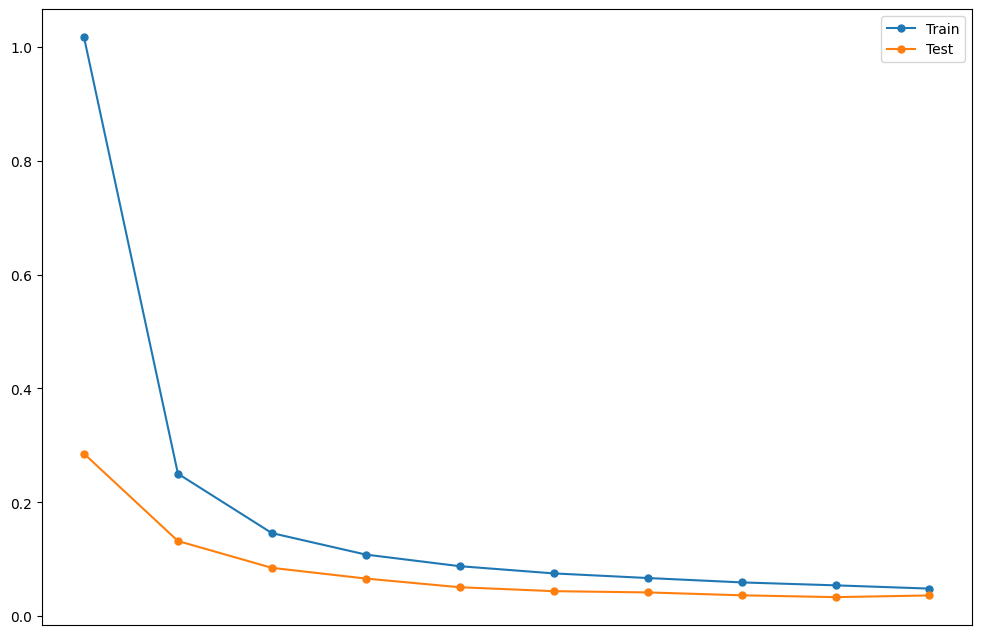

In [219]:
plotMeasure(history3_df.loss, history3_df.val_loss)

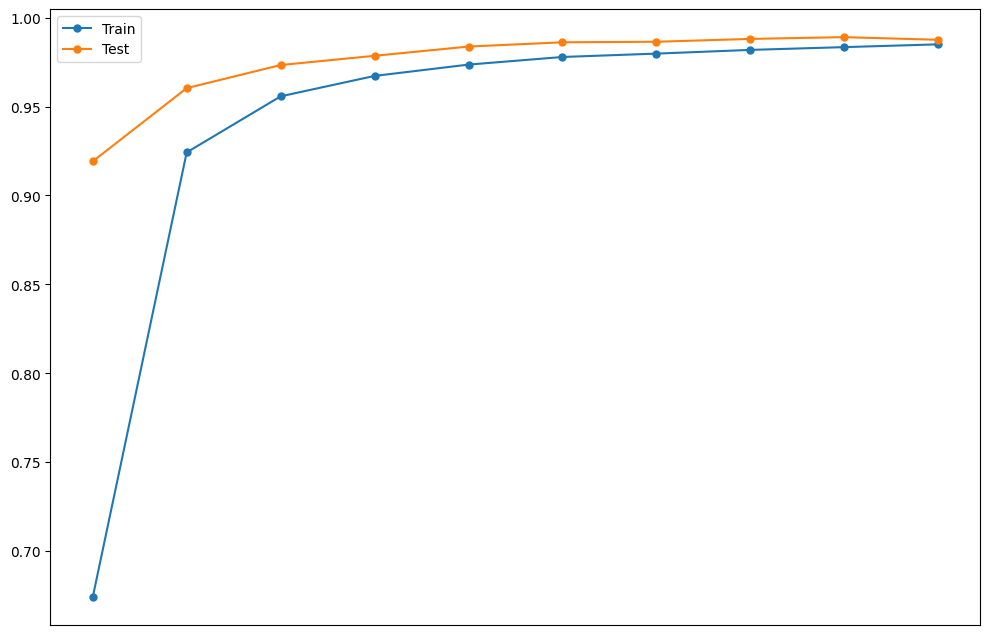

In [220]:
plotMeasure(history3_df.acc, history3_df.val_acc)

In [222]:
predictions_train = np.argmax(model3.predict(X_train_c), axis=-1)

In [223]:
confusion_matrix(y_train, predictions_train)

array([[5902,    2,    0,    0,    1,    0,   10,    1,    3,    4],
       [   0, 6712,    4,    2,    2,    0,    1,   20,    1,    0],
       [  13,   12, 5823,   10,    5,    1,    3,   70,   14,    7],
       [   5,    1,    8, 6016,    0,   29,    0,   39,   15,   18],
       [   3,    6,    0,    0, 5809,    0,    4,    3,    1,   16],
       [   3,    1,    1,    5,    2, 5375,   19,    3,    7,    5],
       [   9,    7,    1,    1,    8,    6, 5881,    0,    5,    0],
       [   0,    4,    3,    0,    3,    0,    0, 6246,    2,    7],
       [  13,   20,    6,    4,   12,   24,   11,   10, 5725,   26],
       [  11,    4,    0,    1,   29,    7,    1,   38,    9, 5849]])

In [224]:
accuracy_score(y_train, predictions_train)

0.9889666666666667

In [225]:
meas = precision_recall_fscore_support(y_train, predictions_train, average=None)
print('Training set')
for i in range(10):
  print(f'Class {i}, {meas[3][i]} elements: precision={meas[0][i]:5.2f}, recall={meas[1][i]:5.2f}, f-score={meas[2][i]:5.2f}')

Training set
Class 0, 5923 elements: precision= 0.99, recall= 1.00, f-score= 0.99
Class 1, 6742 elements: precision= 0.99, recall= 1.00, f-score= 0.99
Class 2, 5958 elements: precision= 1.00, recall= 0.98, f-score= 0.99
Class 3, 6131 elements: precision= 1.00, recall= 0.98, f-score= 0.99
Class 4, 5842 elements: precision= 0.99, recall= 0.99, f-score= 0.99
Class 5, 5421 elements: precision= 0.99, recall= 0.99, f-score= 0.99
Class 6, 5918 elements: precision= 0.99, recall= 0.99, f-score= 0.99
Class 7, 6265 elements: precision= 0.97, recall= 1.00, f-score= 0.98
Class 8, 5851 elements: precision= 0.99, recall= 0.98, f-score= 0.98
Class 9, 5949 elements: precision= 0.99, recall= 0.98, f-score= 0.98


In [227]:
predictions_test = np.argmax(model3.predict(X_test_c), axis=-1)

In [228]:
confusion_matrix(y_test, predictions_test)

array([[ 976,    0,    0,    0,    0,    0,    1,    1,    2,    0],
       [   0, 1131,    0,    0,    0,    1,    1,    2,    0,    0],
       [   3,    2, 1008,    0,    2,    0,    0,   14,    3,    0],
       [   0,    0,    0,  995,    0,    5,    0,    8,    2,    0],
       [   0,    0,    0,    0,  979,    0,    0,    1,    0,    2],
       [   2,    0,    0,    3,    0,  884,    1,    2,    0,    0],
       [   7,    3,    0,    0,    4,    4,  939,    0,    1,    0],
       [   0,    0,    2,    0,    0,    0,    0, 1022,    1,    3],
       [   5,    0,    1,    0,    1,    1,    0,    6,  956,    4],
       [   2,    4,    0,    0,    7,    1,    0,    8,    1,  986]])

In [229]:
accuracy_score(y_test, predictions_test)

0.9876

In [230]:
meas = precision_recall_fscore_support(y_test, predictions_test, average=None)
print('Test set')
for i in range(10):
  print(f'Class {i}, {meas[3][i]} elements: precision={meas[0][i]:5.2f}, recall={meas[1][i]:5.2f}, f-score={meas[2][i]:5.2f}')

Test set
Class 0, 980 elements: precision= 0.98, recall= 1.00, f-score= 0.99
Class 1, 1135 elements: precision= 0.99, recall= 1.00, f-score= 0.99
Class 2, 1032 elements: precision= 1.00, recall= 0.98, f-score= 0.99
Class 3, 1010 elements: precision= 1.00, recall= 0.99, f-score= 0.99
Class 4, 982 elements: precision= 0.99, recall= 1.00, f-score= 0.99
Class 5, 892 elements: precision= 0.99, recall= 0.99, f-score= 0.99
Class 6, 958 elements: precision= 1.00, recall= 0.98, f-score= 0.99
Class 7, 1028 elements: precision= 0.96, recall= 0.99, f-score= 0.98
Class 8, 974 elements: precision= 0.99, recall= 0.98, f-score= 0.99
Class 9, 1009 elements: precision= 0.99, recall= 0.98, f-score= 0.98
